In [1]:
import os
import torch
import sys

from base64 import b64encode
from cotracker3.utils.visualizer import Visualizer, read_video_from_path, read_frames_from_folder
from IPython.display import HTML
import numpy as np

In [2]:
%cd /usr/mvl2/ksgh2/Documents/projects/PointTracking/coTracker3/co-tracker

/usr/mvl2/ksgh2/Documents/projects/PointTracking/coTracker3/co-tracker


In [3]:
def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")

# show_video("assets/apple.mp4")

In [4]:
# CoTracker 3
from cotracker3.predictor import CoTrackerPredictor

model = CoTrackerPredictor(
    checkpoint=os.path.join(
        'checkpoints/cotracker3_offline.pth'
    )
)

/usr/mvl2/ksgh2/Documents/projects/PointTracking/coTracker3/co-tracker/cotracker3/models/build_cotracker.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = to

In [6]:
video = read_video_from_path('/usr/mvl2/ksgh2/Documents/projects/LightFeatureTracking/results/cmphExm/aliked/aliked_horse_bailey.mp4')

# video = read_frames_from_folder('/usr/mvl2/ksgh2/Documents/projects/Datasets/data/Horse_Datasets/Horse_Keegan_Oct24/stanley/image_sequences/org/2_lungeleft/')
# video = read_frames_from_folder('/usr/mvl2/ksgh2/Documents/projects/omnimotion/preprocessing/horse-dataset/color')
if video is not None:
    # Separate frames from index 0 to 100
    video = video[0:100].copy()
    print(f"Loaded {video.shape[0]}")
    video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float()


Loaded 80


In [7]:
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    model = model.to(device)
    video = video.to(device)

In [8]:
import torch

# queries = torch.tensor([ # Stanley 2, lungeleft
#     # [0., 635, 733],
#     # [0., 858, 258],
#     # [0., 236, 224]
#     [0., 1124, 290], # Head 
#     [0., 985, 905], # Foot
#     [0., 250, 332], # Pelvis
#     [0., 1859, 67], # Wall 1, 0
#     [60., 1748, 45], # Wall 2, 0
# ])

# queries = torch.tensor([ # Stanley 3, lungeright
#     [0., 240, 215], # Head 
#     [0., 1215, 246], # Pelvis
#     [0., 624, 884], # Foot
# ])

queries = torch.tensor([ # Bailey 3, lungeleft
    [0., 1096, 306], # Head 
    [0., 1604, 445], # Pelvis
    # [0., 1280, 744], # Foot
])

# queries = torch.tensor([ # Omni Video
#     [0., 783, 235], # Head 
#     [0., 329, 335], # Pelvis
#     [0., 959, 153], # wall
    
# ])

if torch.cuda.is_available():
    queries = queries.to(device)


In [9]:
pred_tracks, pred_visibility = model(video, queries=queries[None])
a = 0

In [ ]:
import matplotlib.pyplot as plt


tracks_np = pred_tracks.detach().cpu().numpy()

# Remove the batch dimension (since it's 1)
# Shape becomes: (100, 3, 2) -> (frames, points, xy)
tracks_no_batch = tracks_np[0]

# Extract the y-coordinates for all points across all frames
# We want slice :, :, 1 -> all frames, all points, the y-coordinate (index 1)
# Shape becomes: (100, 3) -> (frames, points)
y_coordinates = tracks_no_batch[:, :, 1]
loaded_smooth_signal_y1 = np.load('/usr/mvl2/ksgh2/Documents/projects/LightFeatureTracking/results/horse/smooth_signal_y1.npy')
# loaded_smooth_signal_y1 = np.concatenate(([loaded_smooth_signal_y1[0]], loaded_smooth_signal_y1[1:] + loaded_smooth_signal_y1[:-1]))

# loaded_smooth_signal_y1N = np.array([
#     loaded_smooth_signal_y1[i] if i == 0 
#     else loaded_smooth_signal_y1[i] + loaded_smooth_signal_y1[i-1] 
#     for i in range(len(loaded_smooth_signal_y1))
# ])

# new_sum_y1 = np.empty_like(loaded_smooth_signal_y1)
# new_sum_y1[0] = loaded_smooth_signal_y1[0]                      # or whatever you’d like the “previous” of the 0th element to be
# new_sum_y1[1:] = loaded_smooth_signal_y1[1:] + loaded_smooth_signal_y1[:-1]

new_sum_y1 = np.cumsum(loaded_smooth_signal_y1)

final_y1 = np.append(new_sum_y1, new_sum_y1[-1])
y_coordinates_corrected = y_coordinates + final_y1[:,None] 

# Get the number of frames and points from the extracted data
num_frames = y_coordinates.shape[0]
num_points = y_coordinates.shape[1]

# Create an array representing the frame numbers (0, 1, 2, ..., num_frames-1)
frame_numbers = np.arange(num_frames)

# --- 3. Plotting ---

plt.figure(figsize=(12, 6)) # Adjust figure size as needed

# Loop through each point track and plot its y-coordinate vs frame number
# for i in range(num_points):
#     plt.plot(frame_numbers, y_coordinates[:, i], label=f'Point {i+1}')


plt.plot(frame_numbers, y_coordinates[:, 0], label='Head', linewidth=4)
plt.plot(frame_numbers, y_coordinates_corrected[:, 0], label='Head_corrected', linewidth=4)

plt.plot(frame_numbers, y_coordinates[:, 1], label='Pelvis', linewidth=4)
plt.plot(frame_numbers, y_coordinates_corrected[:, 1], label='Pelvis_corrected', linewidth=4)

plt.savefig('y_coordinates_over_time_abs.png', dpi=900, bbox_inches='tight')
# Add labels and title
plt.xlabel("Frame Number")
plt.ylabel("Y-coordinate")
plt.title("Y-coordinate of Tracked Points over Time")
plt.legend() # Show the legend to identify which line corresponds to which point
plt.grid(True) # Add a grid for better readability
plt.show()

In [25]:
y_coordinates.shape

(80, 2)

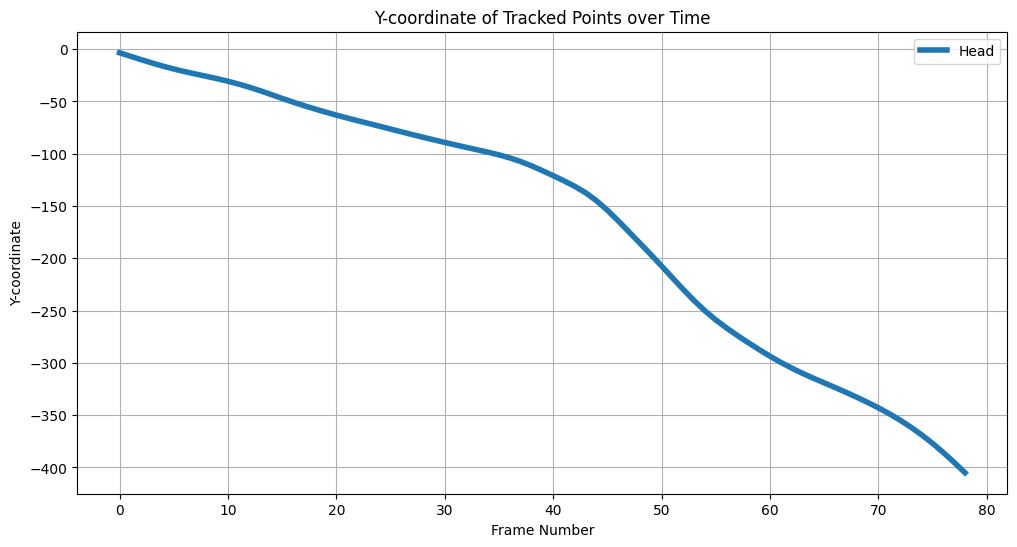

In [31]:


plt.figure(figsize=(12, 6)) # Adjust figure size as needed

# Loop through each point track and plot its y-coordinate vs frame number
# for i in range(num_points):
#     plt.plot(frame_numbers, y_coordinates[:, i], label=f'Point {i+1}')


plt.plot(frame_numbers[:-1], new_sum_y1, label='Head', linewidth=4)

# Add labels and title
plt.xlabel("Frame Number")
plt.ylabel("Y-coordinate")
plt.title("Y-coordinate of Tracked Points over Time")
plt.legend() # Show the legend to identify which line corresponds to which point
plt.grid(True) # Add a grid for better readability
plt.show()

In [14]:
print(y_coordinates.shape)
print(loaded_smooth_signal_y1.shape)

(80, 2)
(80,)


In [ ]:
vis = Visualizer(
    save_dir='./videos',
    linewidth=3,
    mode='cool',
    tracks_leave_trace=20,
    fps=30
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='queries_video_co3_wall')